# Intro

Here, we take the models generated in 'Models.ipynb' and evaluate their performance using accuracy and the ROC curve. We also explore voting classifiers that form a prediction based on a weighted input of predictions from all the other models.

# Load packages

In [1]:
# Saving models
import joblib

# Data manipulation
import numpy as np
import pandas as pd 

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Model evaluation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, roc_curve
from sklearn.ensemble import VotingClassifier

# Load data

Separate back into train and test (i.e. submission) sets

In [2]:
df = pd.read_csv('./data/df_full.csv',index_col='PassengerId')

tr = ~df['Survived'].isnull()

y = df[tr]['Survived'].to_numpy().astype(int)
X = df[tr].drop('Survived',1)

sub = df[~tr].drop('Survived',1)

# Load models

Reload models generated in an earlier notebook and save them in a list.

In [3]:
knn = joblib.load('./models/best_knn.joblib')
logreg = joblib.load('./models/best_logreg.joblib')
svc = joblib.load('./models/best_svc.joblib')
rf = joblib.load('./models/best_rf.joblib')
xgb = joblib.load('./models/best_xgb.joblib')

models = [knn,logreg,svc,rf,xgb]
model_names = ['knn','logreg','svc','rf','xgb']

# Evaluate accuracy

Here we iterate through the models and evaluate their accuracy using a stratified 10-fold split.

In [4]:
mean_accs = []
for i in range(len(models)):
    name = model_names[i]
    model = models[i]

    acc = []
    
    for j, (train, test) in enumerate(StratifiedKFold(10).split(X,y)):
        fold_clf = model.fit(X.iloc[train],y[train])
        acc.append(fold_clf.score(X.iloc[test],y[test]))
        
    mean_acc = np.mean(acc)
    mean_accs.append(mean_acc)
    std_acc = np.std(acc)
    print(f'{name} : {mean_acc:.4f} +- {std_acc:.4f}')

knn : 0.8238 +- 0.0408
logreg : 0.8362 +- 0.0302
svc : 0.8418 +- 0.0302
rf : 0.8429 +- 0.0340
xgb : 0.8451 +- 0.0335


## Results

The XGBoost model had the highest average accuracy, followed by random forest, SVC, logistic regression, and KNN. 

# Voting classifiers

Let's see if we can improve performance by using a voting classifier. We will look at two approaches: "hard" voting, which assigns classes based on majority votes of all classifiers, and "soft" voting which assigns weighted probabilities from each classifier towards each class - in this case weighted by the mean accuracy of each classifier acting alone. The label with the highest sum of weighted probabilities is the prediction.

In [5]:
vc_hard = VotingClassifier(estimators = [(name, model) for name, model in zip(model_names, models)],
                     voting='hard',
                     n_jobs=32)
vc_hard.fit(X,y);

vc_soft = VotingClassifier(estimators = [(name, model) for name, model in zip(model_names, models)],
                     voting='soft',
                     weights=mean_accs,
                     n_jobs=32)
vc_soft.fit(X,y);

Let's see the accuracy of the voting classifiers:

In [6]:
for model, name in zip([vc_hard, vc_soft],['vc_hard','vc_soft']):

    acc = []
    
    for j, (train, test) in enumerate(StratifiedKFold(10).split(X,y)):
        fold_clf = model.fit(X.iloc[train],y[train])
        acc.append(fold_clf.score(X.iloc[test],y[test]))
        
    mean_acc = np.mean(acc)
    std_acc = np.std(acc)
    print(f'{name} : {mean_acc:.4f} +- {std_acc:.4f}')

vc_hard : 0.8429 +- 0.0308
vc_soft : 0.8418 +- 0.0294


## Results

Here, the voting classifiers actually both performed slightly worse than the XGBoost classifier acting alone. In this case, the contributions from the weaker classifiers diluted the performance of the best individual classifier.

Moving on, we save the voting classifiers and add them to our list of models:

In [7]:
joblib.dump(vc_hard, 'models/best_vchard.joblib')
joblib.dump(vc_soft, 'models/best_vcsoft.joblib')

model_names = model_names + ['vchard','vcsoft']
models = models + [vc_hard, vc_soft];

# ROC Analysis

For another evaluation, we use each classifier to construct ROC curves, evaluating the tradeoff in false positive fraction and true positive fraction as a function of the decision function. The ROC curves can be summarized by the area-under-the-curve (AUC) metric, where a value of 0.5 indicates random guessing, and 1.0 is perfect classification. (Note that the hard-voting classifier is ignored for this metric as it does not provide a target label probability)

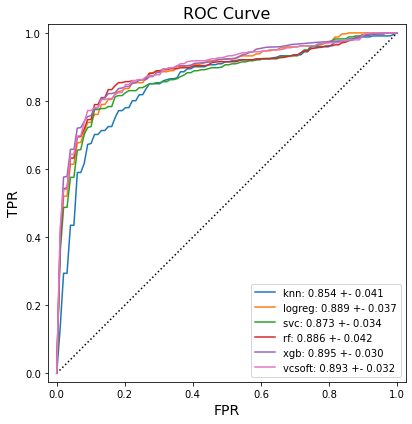

In [8]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot([0,1],[0,1],'k:')

fpr = np.linspace(0,1,100)
for i in range(len(models)):
    name = model_names[i]
    model = models[i]
        
    tprs = []
    aucs = []
    
    for j, (train, test) in enumerate(StratifiedKFold(10).split(X,y)):
        fold_clf = model.fit(X.iloc[train],y[train])
        if name != 'vchard':
            fold_fpr, fold_tpr, _ = roc_curve(y[test], fold_clf.predict_proba(X.iloc[test])[:, 1])
            interp_tpr = np.interp(fpr,fold_fpr,fold_tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(auc(fold_fpr,fold_tpr))
        
        
    if name != 'vchard':
        mean_tpr = np.mean(tprs,axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(fpr, mean_tpr, 
                label=f"{name}: {mean_auc:.3f} +- {std_auc:.3f}",
                color=f'C{i}')

ax.set_title("ROC Curve",fontsize=16)
ax.set_xlabel("FPR",fontsize=14)
ax.set_ylabel("TPR",fontsize=14)
ax.set_xlim([-0.025,1.025])
ax.set_ylim([-0.025,1.025])
ax.set_aspect('equal')
ax.legend(loc="best")
fig.tight_layout();

## Results

Once again, the XGBoost led to the best performance, indicated by the highest AUC metric.

# Submission

To wrap things up, we use all of our models to make predictions about the test set and save our results to .csv files for submission to kaggle. 

In [9]:
for i in range(len(models)):
    model = models[i]
    model.fit(X,y)
    pred = pd.DataFrame()
    pred['PassengerId'] = sub.index
    pred['Survived'] = model.predict(sub)
    pred.to_csv(f'./submissions/{model_names[i]}_final.csv',index=False)